In [1]:
#adapted from Thomas Simonini's implementation
#https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Q%20learning/FrozenLake/Q%20Learning%20with%20FrozenLake.ipynb

import numpy as np
import gym
import random
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from datetime import datetime

In [2]:
map = 'FrozenLake8x8-v1'
#map = 'FrozenLake-v1'
b_slip = True
#custom=["SFFF", "FFFF", "FFFF", "FFFG"]
#env = gym.make("FrozenLake-v1", desc= custom)
env = gym.make(map, is_slippery=b_slip)

#env = gym.wrappers.time_limit.TimeLimit(env, max_episode_steps=500)
#print(env.spec.max_episode_steps)
action_size = env.action_space.n
state_size = env.observation_space.n
qtable = np.zeros((state_size, action_size))

In [13]:
def generate_random_map(size=8, p=0.0):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is a hole
    """
    valid = False

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0, 0))
        while frontier:
            r, c = frontier.pop()
            if not (r, c) in discovered:
                discovered.add((r, c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == "G":
                        return True
                    if res[r_new][c_new] != "H":
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(["F", "H"], (size, size), p=[p, 1 - p])
        res[0][0] = "S"
        res[-1][-1] = "G"
        valid = is_valid(res)
    return ["".join(x) for x in res]

generate_random_map(size=8, p=0.5)

['SFFHFFFF',
 'HHFFHHHF',
 'FFFFHHHF',
 'FHFFFHHH',
 'FHFFFHFF',
 'HHFFFHHH',
 'FHFFFHHF',
 'FHHHFFFG']

In [3]:
# Train model
# default values for parameter experiments
def train_model(total_episodes: int=20000, learning_rate: float=0.6, max_steps: int=200, gamma: float=0.6, 
                epsilon: float=1, max_epsilon: float=1, min_epsilon: float=0.0001, decay_rate: float=0.00005) -> list:
    ep_reward = []
    rewards_1000 = []

    for episode in range(total_episodes):
        # Reset the environment
        state = env.reset()
        step = 0
        done = False
        total_rewards = 0
        
        for step in range(max_steps):
            # 3. Choose an action a in the current world state (s)
            ## First we randomize a number
            exp_exp_tradeoff = random.uniform(0, 1)
            
            ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
            if exp_exp_tradeoff > epsilon:
                action = np.argmax(qtable[state,:])

            # Else doing a random choice --> exploration
            else:
                action = env.action_space.sample()

            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done, info = env.step(action)

            # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            # qtable[new_state,:] : all the actions we can take from new state
            qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
            
            total_rewards += reward
            
            # Update state
            state = new_state
            
            # Finish episode if agent reaches reward or hole
            if done == True: 
                break
            
        # Reduce epsilon (because we need less and less exploration)
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
        ep_reward.append(total_rewards)

    rewards_1000 = np.add.reduceat(ep_reward, np.arange(0, len(ep_reward), 1000))
    #print(rewards_1000[-1])
    print(epsilon)
    #write_files(qtable, rewards_1000, total_episodes, learning_rate, gamma, min_epsilon, decay_rate)
    return [qtable, rewards_1000]



In [ ]:
def write_files(qtable: np.ndarray, rewards_1000, total_episodes: int, learning_rate: float, gamma: float, 
                min_epsilon: float, decay_rate: float):

    file_name = (str(total_episodes) +'_'+ str(learning_rate) +'_'+ str(gamma) +'_'+
                 str(min_epsilon) +'_'+ str(decay_rate))
    # path = Path(map)
    # path.mkdir(exist_ok=True)
    # with open (map + '\\' + file_name+'.txt', 'w') as f:
    #     f.write('Total reward in final 1000 episodes: ' + str(rewards_1000[-1]) + '\n' +
    #             'Total episodes: ' + str(total_episodes) + '\n' +
    #             'Learning rate: ' + str(learning_rate) + '\n' +
    #             'Gamma: ' + str(gamma) + '\n' +
    #             'Min epsilon: ' + str(min_epsilon) + '\n' +
    #             'Decay rate: ' + str(decay_rate) + '\n \n' +
    #             str(qtable))

    # plt.plot(np.arange(0, total_episodes/1000), rewards_1000)
    # plt.savefig(map + '\\'+file_name +'.png')
    # plt.close

In [10]:
def test_model(qtable: np.ndarray, max_steps: int=200):
    env.reset()

    total_reward = 0
    total_episodes = 100
    for episode in range(total_episodes):
        state = env.reset()
        step = 0
        done = False
        print("****************************************************")
        print("EPISODE ", episode)

        for step in range(max_steps):
            # Take the action (index) that have the maximum expected future reward given that state
            action = np.argmax(qtable[state,:])
            
            new_state, reward, done, info = env.step(action)
            
            if done:
                # Here, we decide to only print the last state (to see if our agent is on the goal or fall into an hole)
                #env.render()
                
                # We print the number of step it took.
                print("Number of steps", step)
                print("Reward:", reward)
                total_reward += reward
                break
            state = new_state
    print('Total rewards:', total_reward,'/',total_episodes)
    env.close()

SyntaxError: non-default argument follows default argument (3679759047.py, line 1)

In [4]:
# Tuning parameters
#slippery 8x8
#gamma = 0.7344827586 0.8172413793103449 0.7344827586206897
#learning_rate = 0.1
#non-slip 4x4 
# learning_rate = 0.5413793103448277
# gamma = 0.23793103448275865 0.34827586206896555
#slip 4x4
# gamma = 0.8724137931034484

interval = 15
parameter_range = np.linspace(0.1,0.9,interval,endpoint=True)
rewards = []
#rewards_sum = [0]*interval

for i in range(5):
    for parameter in parameter_range:
        for parameter2 in parameter_range:
            # reset qtable
            qtable = np.zeros((state_size, action_size))
            qtable, rewards_1000 = train_model(total_episodes=40000, max_steps=150, learning_rate=parameter, gamma=parameter2, decay_rate=0.0001)
            rewards.append(rewards_1000[-1])

rs_rewards = np.reshape(rewards,(-1,interval,interval))
rs_rewards_mean = np.mean(rs_rewards, axis=0)

now = datetime.now().strftime('%Y%m%d-%H%M')   
pd.DataFrame(rs_rewards_mean).to_csv(now + '.csv')

#print('max reward:',max(rewards_mean), 'index:', rewards_mean.index(max(rewards_mean)))
#print(parameter_range[rewards_mean.index(max(rewards_mean))])
#plt.plot(parameter_range, rewards_mean)

0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.018415638797149875
0.01841563879

0.002578628229761946


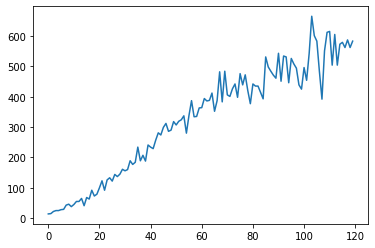

In [5]:
# Tuned parameters
if env.spec.id == 'FrozenLake8x8-v1':
    if b_slip:
        # 8x8 slippery settings #####################################################################
        total_episodes = 120000        # Total episodes
        learning_rate = 0.01           # Learning rate
        max_steps = 200                # Max steps per episode, capped at 100 for 4x4, 200 for 8x8
        gamma = 0.999                  # Discounting rate
        # Exploration parameters
        epsilon = 1.0                 # Exploration rate
        max_epsilon = 1.0             # Exploration probability at start
        min_epsilon = 0.0001          # Minimum exploration probability 
        decay_rate = 0.00005          # Exponential decay rate for exploration prob
    else:
        # 8x8 non-slippery settings  #####################################################################
        total_episodes = 60000        # Total episodes
        learning_rate = 0.75           # Learning rate
        max_steps = 200                # Max steps per episode, capped at 100 for 4x4, 200 for 8x8
        gamma = 0.9                  # Discounting rate
        # Exploration parameters
        epsilon = 1.0                 # Exploration rate
        max_epsilon = 1.0             # Exploration probability at start
        min_epsilon = 0.0001            # Minimum exploration probability 
        decay_rate = 0.00005             # Exponential decay rate for exploration prob

elif env.spec.id == 'FrozenLake-v1':
    if b_slip:
        # 4x4 slippery settings  #####################################################################
        total_episodes = 120000        # Total episodes
        learning_rate = 0.1 #0.15517
           # Learning rate
        max_steps = 200                # Max steps per episode, capped at 100 for 4x4, 200 for 8x8
        gamma = 0.9                  # Discounting rate
        # Exploration parameters
        epsilon = 1.0                 # Exploration rate
        max_epsilon = 1.0             # Exploration probability at start
        min_epsilon = 0.0001            # Minimum exploration probability 
        decay_rate = 0.00005             # Exponential decay rate for exploration prob
    else:
        # 4x4 non-slippery settings  #####################################################################
        total_episodes = 60000        # Total episodes
        learning_rate = 0.5413793103448277           # Learning rate
        max_steps = 200                # Max steps per episode, capped at 100 for 4x4, 200 for 8x8
        gamma = 0.23793103448275865                  # Discounting rate
        # Exploration parameters
        epsilon = 1.0                 # Exploration rate
        max_epsilon = 1.0             # Exploration probability at start
        min_epsilon = 0.0001            # Minimum exploration probability 
        decay_rate = 0.00005             # Exponential decay rate for exploration prob

qtable = np.zeros((state_size, action_size))
qtable, rewards_1000 = train_model(total_episodes, learning_rate, max_steps, gamma, 
                    epsilon, max_epsilon, min_epsilon, decay_rate)
plt.plot(np.arange(0, total_episodes/1000), rewards_1000)

In [9]:
#slippery 8x8 qtable
#test_qtable = np.loadtxt('C:\\Users\\ETCH\\Desktop\\Github\\ANT61 Internship\Week 2\\FrozenLake8x8-v1 slippery\\120000_0.01_0.999_0.0001_5e-05.csv', delimiter =",")
#non-slippery 8x8 qtable
#test_qtable = np.loadtxt('C:\\Users\\ETCH\\Desktop\\Github\\ANT61 Internship\Week 2\\FrozenLake8x8-v1\\60000_0.75_0.9_0.0001_5e-05.csv', delimiter =",")
test_model(qtable=test_qtable)

****************************************************
EPISODE  0
Number of steps 37
Reward: 0.0
****************************************************
EPISODE  1
Number of steps 67
Reward: 1.0
****************************************************
EPISODE  2
Number of steps 64
Reward: 1.0
****************************************************
EPISODE  3
Number of steps 14
Reward: 0.0
****************************************************
EPISODE  4
Number of steps 20
Reward: 1.0
****************************************************
EPISODE  5
Number of steps 23
Reward: 0.0
****************************************************
EPISODE  6
Number of steps 8
Reward: 1.0
****************************************************
EPISODE  7
Number of steps 76
Reward: 1.0
****************************************************
EPISODE  8
Number of steps 51
Reward: 1.0
****************************************************
EPISODE  9
Number of steps 86
Reward: 1.0
***************************************************